![TS banner](banner.png)

# A JWST NIRSpec/G395H transit as seen through `transitspectroscopy`
**Author**: Néstor Espinoza (Assistant Astronomer; Mission Scientist for Exoplanet Science)

**Last updated**: September 11, 2023

## Motivation & Data Description

In this notebook, we aim to obtain a JWST NIRSpec/G395H transit spectrum of [the exoplanet HAT-P-14~b (PID 1118; PI Proffitt)](https://www.stsci.edu/jwst/science-execution/program-information?id=1118) using `transitspectroscopy`. This dataset was obtained during JWST commissioning observations in order to study the spectrophotometric capabilities of the instrument. An initial analysis was shown in [Espinoza et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023PASP..135a8002E/abstract) --- here, we aim to reproduce a sort of "step by step" on how to reproduce (and improve upon!) those results.

As the documentation states, `transitspectroscopy` makes use of Stage 1 of the JWST Calibration Pipeline for most of its detector-level calibration. Because of this we list below the versions of the JWST pipeline and `transitspectroscopy` we will be using:

In [1]:
import jwst
import transitspectroscopy as ts

print('JWST Calibration pipeline version:', jwst.__version__)
print('transitspectroscopy version:', ts.__version__)

JWST Calibration pipeline version: 1.11.3
transitspectroscopy version: 0.4.0


And now let's load a set of helper libraries:

In [166]:
import glob

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('ticks')

<div class="alert alert-block alert-info"> <b>NOTE ON SCREAMING FACE EMOJIS (😱)</b>: In this notebook, we will use the very nice notation introduced on <a href="https://hastie.su.domains/ElemStatLearn/">"The Elements of Statistical Learning"</a> that consider screaming faces (😱) when starting some sections. Whenever you see one, it means the section can be skipped --- the content is interesting if you want a "deep dive" or "deeper knowledge" on the topic being discussed, but it is not needed to continue the tutorial.</div>

## 1. First steps: from raw data to ramps

### 1.1 Downloading the data
To start, let's download the corresponding JWST data. `transitspectroscopy` has a neat download function that uses `astroquery` to get you the data you need. The two things one needs to get this data is **the program ID (1118)** and the **observation number (5)**. Let's use that to download the data:

In [3]:
ts.jwst.download(pid = 1118, obs_num = '5')


	 >> 5.97 GB of data will be downloaded in total considering the following files:

 obsID   obs_collection dataproduct_type ... dataRights calib_level
-------- -------------- ---------------- ... ---------- -----------
83341594           JWST            image ...     PUBLIC           1
83341589           JWST            image ...     PUBLIC           1
83341591           JWST            image ...     PUBLIC           1
83341595           JWST            image ...     PUBLIC           1
83341592           JWST            image ...     PUBLIC           1
83341590           JWST            image ...     PUBLIC           1
83341593           JWST            image ...     PUBLIC           1
83341588           JWST            image ...     PUBLIC           1

	 >> Downloading...


	 >> ...done! Downloaded and stored the following files on the JWSTdata folder:

                                           Filename    Instrument/Mode  \
0  jw01118005001_02101_00001-seg001_nrs1_uncal.fits  BOTS 

This will take a while --- but totally worth the beautiful JWST data! 

<div class="alert alert-block alert-info"> <b>Note:</b> By default, the function downloads the <code>uncal</code> data --- the uncalibrated data. This can be changed to download either ramps or rateints by using the flag <code>data_product</code> on the <code>ts.jwst.download</code> call (e.g., <code>ts.jwst.download(pid = 1118, obs_num = '5', data_product="rateints")</code> will download the rates per integration; <code>data_product="ramps"</code> downloads the calibrated ramps). </div>

In the output above, there's two things to note. First, there's "segments" of data, with filenames names including the words `seg001`, `seg002`, etc. Those are [data segments](https://jwst-docs.stsci.edu/getting-started-with-jwst-data/understanding-jwst-data-files/jwst-data-products): the ground mechanism for processing the data segments the entire TSO dataset into little pieces so it's easier to reduce, analyze and download the data. In addition, one can see there's two groups of `uncal` data that were downloaded --- the ones obtained in the `SUB32` subarray and the ones obtained in the `SUB2048` subarray. The latter are the ones that hold the transit, and they come in two detectors for the NIRSpec/G395H mode we are using here, NRS1 (3-4 microns) and NRS2 (4-5 microns); the former are [Target Acquisition images](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-target-acquisition/nirspec-wide-aperture-target-acquisition) that we will not analyze in this notebook.

### 1.2 Detector-level calibration

Now we have the data --- let's calibrate it! First, we perform detector-level calibration using `transitspectroscopy`. By default, the library performs the standard set of steps using STScI's [JWST Calibration Pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html) with some modifications depending on the instrument. For this NIRSpec/G395H data, the modification is in the jump-step: `transitspectroscopy` performs its own TSO-based jump detection algorithm by default.


To perform this, we first need to setup a list with the names of the files that we will be reducing. The download function above automatically downloads the data to a folder called `JWSTdata`. Note, as described above, there's data from two detectors --- let's extract filenames on lists for those:

In [3]:
nrs1_filenames = glob.glob('JWSTdata/jw01118005001_04101*nrs1_uncal.fits')
nrs2_filenames = glob.glob('JWSTdata/jw01118005001_04101*nrs2_uncal.fits')

Interesting to note: tools like `glob` don't necessarily sort the segments chronologically:

In [4]:
print(nrs1_filenames)

['JWSTdata/jw01118005001_04101_00001-seg003_nrs1_uncal.fits', 'JWSTdata/jw01118005001_04101_00001-seg002_nrs1_uncal.fits', 'JWSTdata/jw01118005001_04101_00001-seg001_nrs1_uncal.fits']


That's OK, the next function we will use, fixes this for us. 

#### 1.2.1 Loading data --- applying detector-calibration

The `transitspectroscopy` library for JWST data works by loading those datasets in an object; let's load it for NRS1 first:

In [5]:
nrs1_dataset = ts.jwst.load(nrs1_filenames, outputfolder = 'JWSTdata')

	    - Instrument/Mode: NIRSpec/G395H



This will load the three segments of data, and save any outputs in the `JWSTdata` folder (you can use any other folder, of course, to save your products!) under a new folder called `ts_outputs`. Note this sorts the filenames automatically:

In [6]:
nrs1_dataset.filenames

array(['JWSTdata/jw01118005001_04101_00001-seg001_nrs1_uncal.fits',
       'JWSTdata/jw01118005001_04101_00001-seg002_nrs1_uncal.fits',
       'JWSTdata/jw01118005001_04101_00001-seg003_nrs1_uncal.fits'],
      dtype='<U57')

All right! Let's perform some detector-level calibration:

In [7]:
nrs1_dataset.detector_calibration()

	 [START] Detector-level Calibration


	 >> Processing 3 files.

	    - TSO total duration: 6.0 hours
	    - Calibration parameters:
{'dq_init': {}, 'saturation': {}, 'refpix': {}, 'linearity': {'output_dir': 'JWSTdata/ts_outputs', 'save_results': True, 'suffix': 'linearitystep'}, 'dark_sub': {}, 'jump': {'window': 10, 'nsigma': 10}, 'ramp_fit': {'output_dir': 'JWSTdata/ts_outputs', 'save_results': True, 'suffix': 'ramp_fitstep'}, 'superbias': {}, 'group_1f': {}, 'skip': {}}
	 >> Linearity files found. Loading them...

	    - Instrument/Mode: NIRSpec/G395H

	 >> TSO-jump files found. Loading them...

	    - Instrument/Mode: NIRSpec/G395H

	 [END] Detector-level Calibration




Let's explore what happened to this `nrs1_dataset` object --- first, note the data properties. There's three ramps, one for each segment:

In [8]:
len(nrs1_dataset.ramps)

3

And each ramp has gone through detector-level calibration, and are now linearity-corrected, jump-detected products. To check this, let's plot the last 5 groups from a random integration on the second segment of data:

In [9]:
nrs1_dataset.ramps[1].shape

(561, 20, 32, 2048)

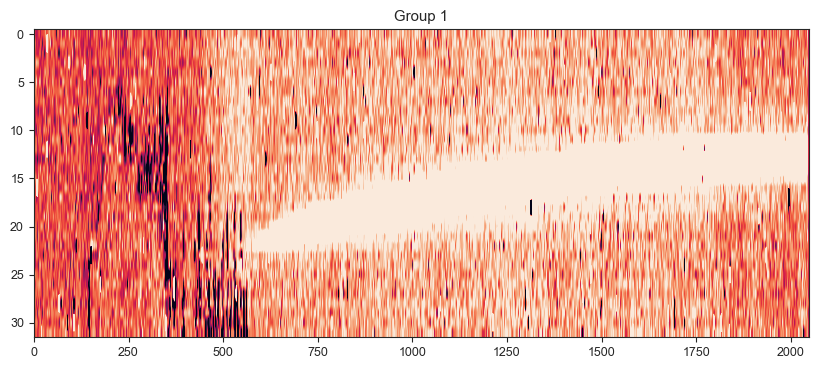

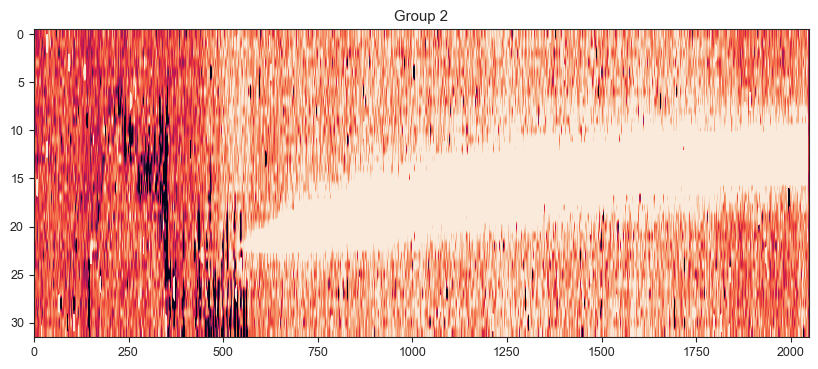

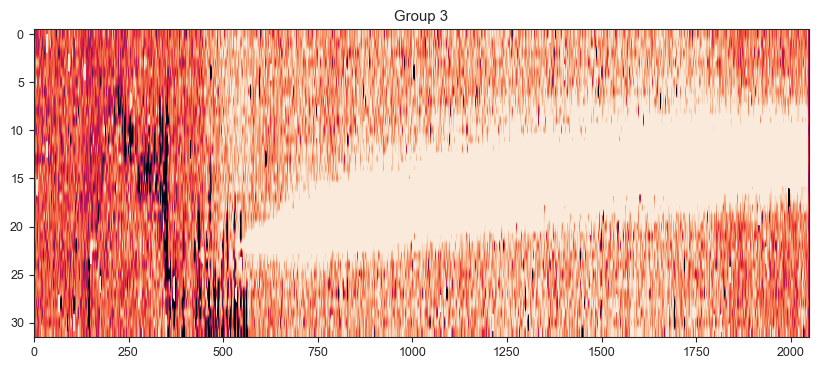

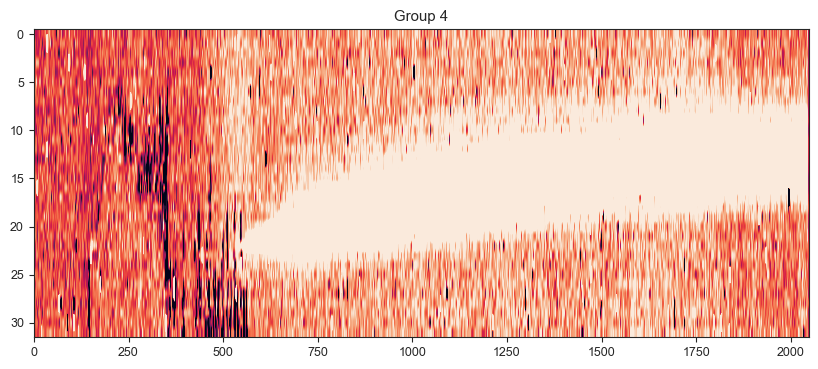

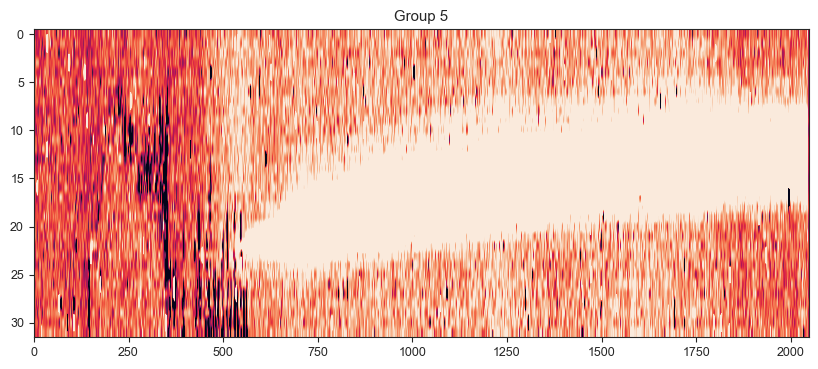

In [167]:
for i in range(0,5):

    plt.figure(figsize=(10,4))
    im = plt.imshow(nrs1_dataset.ramps[1].data[100, i, :, :], aspect = 'auto',)
    plt.title('Group '+str(i+1))
    im.set_clim(-100,100)

Indeed --- up-the-ramp samples happening! 

#### 1.2.2 Fitting the ramps

Let's now perform ramp-fitting. This uses the ramp-fitting step from the JWST pipeline directly, and applies it to our data:

In [10]:
nrs1_dataset.fit_ramps()

	 >> Rampfit files found for jw01118005001_04101_00001-seg001_nrs1. Loading them...

	 >> Rampfit files found for jw01118005001_04101_00001-seg002_nrs1. Loading them...

	 >> Rampfit files found for jw01118005001_04101_00001-seg003_nrs1. Loading them...



Perfect! Let's repeat steps for NRS2:

In [142]:
nrs2_dataset = ts.jwst.load(nrs2_filenames, outputfolder = 'JWSTdata')
nrs2_dataset.detector_calibration()
nrs2_dataset.fit_ramps()

	    - Instrument/Mode: NIRSpec/G395H

	 [START] Detector-level Calibration


	 >> Processing 3 files.

	    - TSO total duration: 6.0 hours
	    - Calibration parameters:
{'dq_init': {}, 'saturation': {}, 'refpix': {}, 'linearity': {'output_dir': 'JWSTdata/ts_outputs', 'save_results': True, 'suffix': 'linearitystep'}, 'dark_sub': {}, 'jump': {'window': 10, 'nsigma': 10}, 'ramp_fit': {'output_dir': 'JWSTdata/ts_outputs', 'save_results': True, 'suffix': 'ramp_fitstep'}, 'superbias': {}, 'group_1f': {}, 'skip': {}}
	 >> Linearity files found. Loading them...

	    - Instrument/Mode: NIRSpec/G395H

	 >> TSO-jump files found. Loading them...

	    - Instrument/Mode: NIRSpec/G395H

	 [END] Detector-level Calibration


	 >> Rampfit files found for jw01118005001_04101_00001-seg001_nrs2. Loading them...

	 >> Rampfit files found for jw01118005001_04101_00001-seg002_nrs2. Loading them...

	 >> Rampfit files found for jw01118005001_04101_00001-seg003_nrs2. Loading them...



All right! The `rateints` are stored in the same object for one to explore. As expected, we have...

In [143]:
print(len(nrs1_dataset.rateints), 'products per segment for NRS1, and',len(nrs1_dataset.rateints),'for NRS2')

3 products per segment for NRS1, and 3 for NRS2


Neat!

### 😱 1.3 Exploring detector-calibration results: `nan` pixels in ramps

Before, we have performed ramp-fitting: that is, fitted the ramps with lines to obtain the so-called "rates per integration". This gives, thus, one "rate" image per integration. Let's study how these look like.

Let's first look at the 100th integration of the 2nd segment of data to see how the rates are looking like:

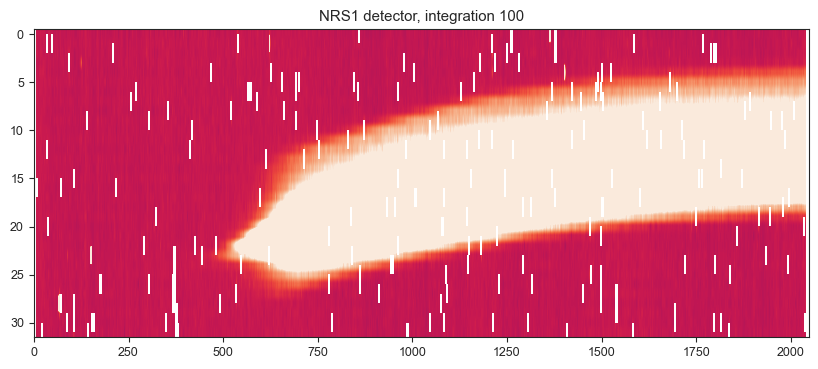

In [168]:
plt.figure(figsize=(10,4))
plt.title('NRS1 detector, integration 100')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
im.set_clim(-10,10)

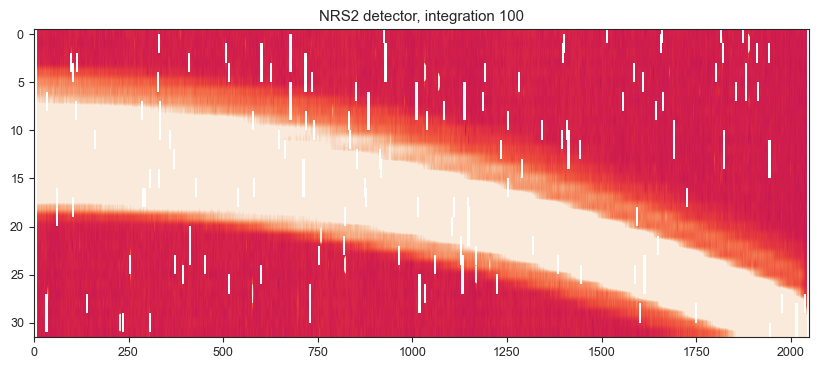

In [169]:
plt.figure(figsize=(10,4))
plt.title('NRS2 detector, integration 100')
im = plt.imshow(nrs2_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
im.set_clim(-10,10)

Rates are looking good, although plots like this are interesting because we do see some pixels marked as white. As it turns out, those are `nan` values! How many are there on each detector on integration 100?

In [144]:
print('Number of nan in NRS1, integration 100, segment 2:', len(np.where(np.isnan(nrs1_dataset.rateints[1].data[100, :, :]))[0]))
print('Number of nan in NRS2, integration 100, segment 2:', len(np.where(np.isnan(nrs2_dataset.rateints[1].data[100, :, :]))[0]))

Number of nan in NRS1, integration 100, segment 2: 547
Number of nan in NRS2, integration 100, segment 2: 601


On the order of ~600 on both detectors, which is about 0.91% of the pixels. This is a little bit under twice the number of [non-operable pixels](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-detectors/nirspec-detector-performance) which might rise an initial question about their origin. Let's explore this!

#### 1.3.1 Exploring non-operable pixels through pixel data-quality (`pixeldq`)

Our first suspect on those `nan` pixels is the pipeline. Could it be the processing itself the one that is giving rise to those `nan` values? To explore this, let's first note `transitspectroscopy` gives us a hint in terms of the pipeline and *context* around which these results were obtained:

In [22]:
for params in ['Ramp-fitting STScI Pipeline Version', 'Ramp-fitting CRDS context']:

    print(params, nrs1_dataset.calibration_parameters[params])

Ramp-fitting STScI Pipeline Version 1.11.3
Ramp-fitting CRDS context jwst_1123.pmap


This is important in case we find something interesting and [we want to report it](https://jwst-docs.stsci.edu/jwst-help-desk). 

First, let us get familiar with the fact that white pixels above are `nan`; let's print the values for NRS1, column 752, which seems to have one of those white pixels:

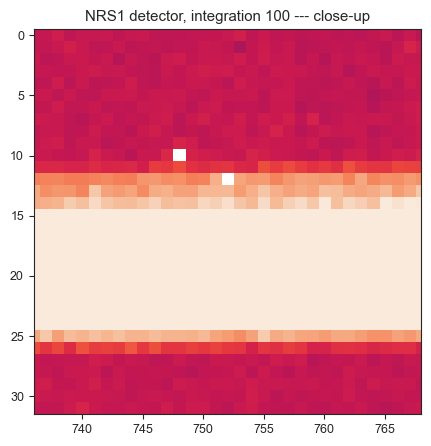

In [170]:
plt.figure(figsize=(5,5))
plt.title('NRS1 detector, integration 100 --- close-up')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
plt.xlim(752-16,752+16)
im.set_clim(-10,10)

In [30]:
nrs1_dataset.rateints[1].data[100, :, 752]

array([-9.8871924e-02, -3.3673489e-01, -2.1998818e-01,  1.6637030e-01,
       -7.5028551e-01, -2.2644097e-01, -5.2583468e-01, -2.9469073e-01,
        8.4030166e-02, -2.1537757e-01, -8.4375434e-02,  1.5087349e+00,
                  nan,  7.4087372e+00,  9.3609076e+00,  1.2132249e+01,
        2.1443344e+01,  3.4084160e+01,  1.1266605e+02,  5.7615472e+02,
        1.1768058e+03,  2.3638702e+02,  5.6952450e+01,  2.9846521e+01,
        1.3485019e+01,  5.9979992e+00,  1.6897780e+00, -8.4474772e-02,
       -2.4862169e-01, -5.6544967e-02, -3.0937231e-01, -6.3854182e-01],
      dtype='>f4')

Hmmm. Interesting. It seems this is at row number 12:

In [32]:
nrs1_dataset.rateints[1].data[100, 12, 752]

nan

Bingo! Let's check first other integrations. Do they all have `nan`s?

In [33]:
nrs1_dataset.rateints[1].data[:, 12, 752]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

Holy Oleo, Batman! That's a lot of `nan`. Let's explore the ramp of integration 100 --- is it particularly bad, perhaps? (Calibrated) ramps are stored in `nrs1_dataset.ramps` --- let's get the one for this pixel. To compare, let's plot the ones to the left and right of it, too:

In [151]:
nrs1_dataset.ramps[1].data.shape

(561, 20, 32, 2048)

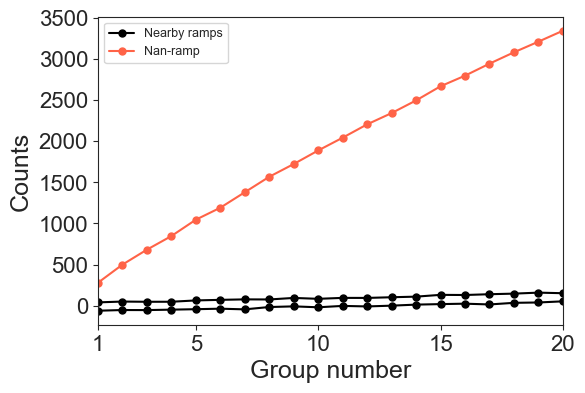

In [177]:
plt.figure(figsize=(6,4))

plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 751], 'o-', color = 'black', label = 'Nearby ramps')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 753], 'o-', color = 'black')

plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 752], 'o-', color = 'tomato', label = 'Nan-ramp' )

plt.xlabel('Group number', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)

plt.xticks([0, 4, 9, 14, 19], 
           ['1', '5', '10', '15', '20'],
           fontsize = 16)

plt.yticks(fontsize = 16)


plt.xlim(0, 19)

plt.legend()

Ah. Indeed, the pixel does seem special. It has much higher counts than pixels around it. There's an array, the `pixeldq` array, which showcases the pixel `d`ata `q`uality --- so  What does the data-quality says about this pixel?

In [40]:
nrs1_dataset.ramps[1].pixeldq[12, 752]

2049

That number doesn't tell us match. Luckily, there's a function to translate that number to words:

In [41]:
from jwst.datamodels import dqflags

dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[12, 752], mnemonic_map = dqflags.pixel)

{'DO_NOT_USE', 'HOT'}

Ah. A hot pixel! That actually makes a lot of sense. It's set to `DO_NOT_USE` because of this --- and this sets the ramp in the ramp-fitting stage to a `nan`. 

But --- are _all_ those `nan` we see in NRS1 hot pixels? Let's count the `DO_NOT_USE` pixels and check if all have something attached:

In [59]:
x_nan, y_nan = np.where(np.isnan(nrs1_dataset.rateints[1].data[100, :, :]))

all_flags = []

pixeldq_do_not_use = 0
for i in range( len(x_nan) ):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if 'DO_NOT_USE' in flags:

        pixeldq_do_not_use += 1
    
        if len(flags) > 1:
    
            for flag in flags:
    
                if flag != 'DO_NOT_USE':
    
                    all_flags.append(flag)

        else:

            all_flags.append('No details')

In total, there are:

In [60]:
print(pixeldq_do_not_use, 'pixels marked as DO_NOT_USE in the pixeldq.')

251 pixels marked as DO_NOT_USE in the pixeldq.


Yes, those are not _all_ the `nan` pixels (above, we found 547 were `nan`). We'll solve the mistery of the remaining 296 pixels below; for now, let's keep looking at these. First, let's see the histogram of what causes a `DO_NOT_USE` pixel:

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120')])

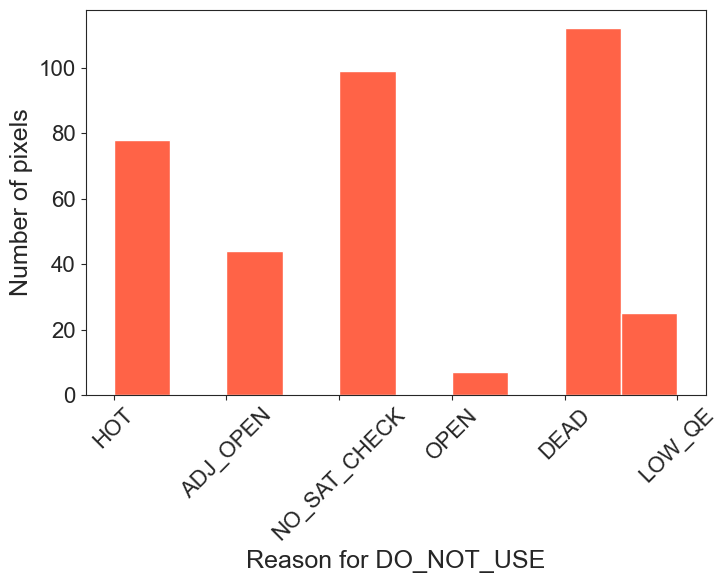

In [187]:
plt.figure(figsize=(8,5))

plt.hist(all_flags, histtype='barstacked', color = 'tomato')
plt.xlabel('Reason for DO_NOT_USE', fontsize = 18)
plt.ylabel('Number of pixels', fontsize = 18)

plt.xticks(fontsize = 16, rotation = 45)

plt.yticks(fontsize = 16)

An explainer of what most each of those reasons mean [can be found in the JWST Documentation](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-detectors/nirspec-detector-performance). Briefly, `DEAD` pixels are the worst because they don't really respond to light. `OPEN` pixels are pixels that have low response, and light leaks into `ADJ_OPEN` pixels; so probably not great for science either. `LOW_QE` have low response to light --- so might be OK in principle for TSOs (just lower SNR). 

`NO_SAT_CHECK` [are pixels that are just not checked for saturation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/description.html). This is because these pixels have no thresholds on their saturation levels (e.g., something went wrong when calculating those and they don't have values) --- and are set as `DO_NOT_USE`. For NIRSpec, pixels that have any of the other flags are not checked for saturation, and thus they end up having `NO_SAT_CHECK`. This highlights an important caveat of the distribution above: pixels might have more than one reason to be flagged as `DO_NOT_USE`.

Let' have a look at a few example of each, for illustration purposes. We already catched a `HOT` pixel. Let's now catch the `OPEN` pixel ramps: 

In [69]:
for i in range( len(x_nan) ):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if 'DO_NOT_USE' in flags:

        if 'OPEN' in flags:
            
            print('Flags:', flags, '(X,Y) pixel coords:', x_nan[i], y_nan[i])

Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 0 1261
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 1 1377
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 24 371
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 26 370
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 27 369
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 27 371
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 30 376


Note all of those are to the left of the spectrum, or above it. So not impacting the signal --- so we won't bother with those in NRS1. What about NRS2?

In [72]:
x_nan2, y_nan2 = np.where(np.isnan(nrs2_dataset.rateints[1].data[100, :, :]))

for i in range( len(x_nan2) ):

    flags = dqflags.dqflags_to_mnemonics(nrs2_dataset.ramps[1].pixeldq[x_nan2[i], y_nan2[i]], mnemonic_map = dqflags.pixel)

    if 'DO_NOT_USE' in flags:

        if 'OPEN' in flags:
            
            print('Flags:', flags, '(X,Y) pixel coords:', x_nan2[i], y_nan2[i])

None of those. Neat! Let's jump to `DEAD` pixels:

In [73]:
for i in range( len(x_nan) ):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if 'DO_NOT_USE' in flags:

        if 'DEAD' in flags:
            
            print('Flags:', flags, '(X,Y) pixel coords:', x_nan[i], y_nan[i])

Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 0 1377
Flags: {'DO_NOT_USE', 'DEAD'} (X,Y) pixel coords: 1 35
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 1 47
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 1 1210
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 1 1211
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 1 1767
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 2 208
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 2 1789
Flags: {'HOT', 'DO_NOT_USE', 'DEAD'} (X,Y) pixel coords: 2 1801
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 3 978
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 3 1178
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 3 1179
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 3 1281
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 4 467
Flags: {'D

Let's check pixel (12, 1716). The `rateints` looks like this:

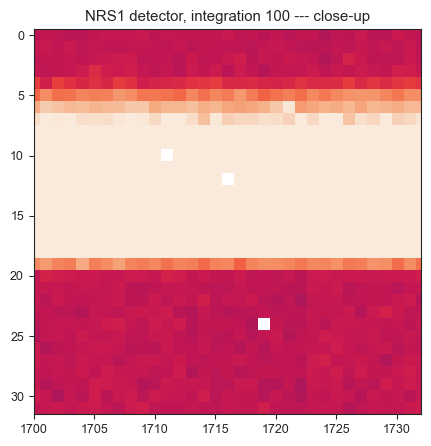

In [190]:
plt.figure(figsize=(5,5))
plt.title('NRS1 detector, integration 100 --- close-up')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
plt.xlim(1716-16,1716+16)
im.set_clim(-10,10)

And the ramp:

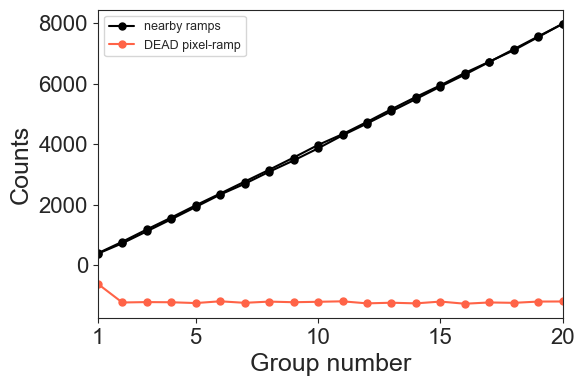

In [188]:
plt.figure(figsize=(6,4))

plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 1717], 'o-', color = 'black', label = 'nearby ramps')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 1715], 'o-', color = 'black')

plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 1716], 'o-', color = 'tomato', label = 'DEAD pixel-ramp' )

plt.xlabel('Group number', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)

plt.xticks([0, 4, 9, 14, 19], 
           ['1', '5', '10', '15', '20'],
           fontsize = 16)

plt.yticks(fontsize = 16)


plt.xlim(0, 19)
plt.legend()

Yep, that's pretty dead. What about `LOW_QE` pixels?

In [77]:
for i in range( len(x_nan) ):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if 'DO_NOT_USE' in flags:

        if 'LOW_QE' in flags:
            
            print('Flags:', flags, '(X,Y) pixel coords:', x_nan[i], y_nan[i])

Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 1 538
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 3 92
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 5 845
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 5 1681
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 7 255
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 7 590
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 7 1892
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 8 521
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 9 140
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 9 691
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 9 1066
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 10 748
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 12 413
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 15 1758
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 17 596
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 17 1005


Let's check pixel (5, 845):

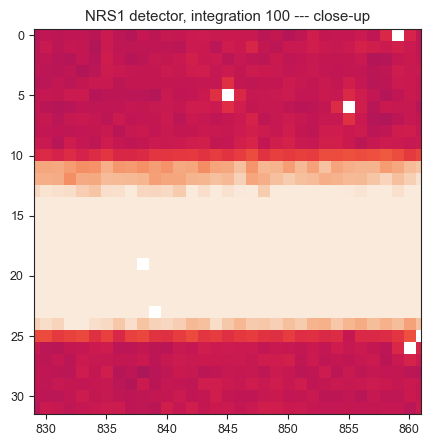

In [189]:
plt.figure(figsize=(5,5))
plt.title('NRS1 detector, integration 100 --- close-up')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
plt.xlim(845-16,845+16)
im.set_clim(-10,10)

Turns out _some_ signal is leaking, just like `OPEN` pixels. Let's see ramps:

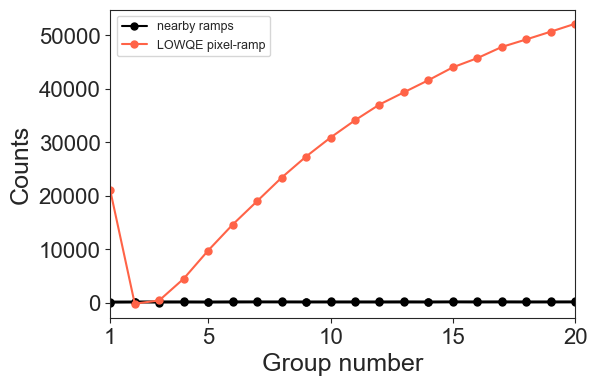

In [191]:
plt.figure(figsize=(6,4))


plt.plot( nrs1_dataset.ramps[1].data[100,:, 5, 845-1], 'o-', color = 'black', label = 'nearby ramps')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 5, 845+1], 'o-', color = 'black')

plt.plot( nrs1_dataset.ramps[1].data[100,:, 5, 845], 'o-', color = 'tomato', label = 'LOWQE pixel-ramp' )

plt.xlabel('Group number', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)

plt.xticks([0, 4, 9, 14, 19], 
           ['1', '5', '10', '15', '20'],
           fontsize = 16)

plt.yticks(fontsize = 16)


plt.xlim(0, 19)
plt.legend()

Well, turns out _that_ pixel is going a bit crazy. So, again, rightfully masked out.

#### 1.3.2 What's with the rest of the pixels? 

So --- from all the `nan` pixels, let's find out the ones that don't have a "rightfully masked out" pixel:

In [124]:
x_nan, y_nan = np.where(np.isnan(nrs1_dataset.rateints[1].data[100, :, :]))

In [134]:
nan_no_dnu = 0
for i in range(len(x_nan)):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if (not 'DO_NOT_USE' in flags):

        print(nan_no_dnu,':',x_nan[i], y_nan[i], ' --- is nan, but not pixeldq flagged:',flags)
        nan_no_dnu += 1

0 : 0 0  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
1 : 0 1  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
2 : 0 2  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
3 : 0 3  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
4 : 0 2043  --- is nan, but not pixeldq flagged: set()
5 : 0 2044  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
6 : 0 2045  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
7 : 0 2046  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
8 : 0 2047  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
9 : 1 0  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
10 : 1 1  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
11 : 1 2  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
12 : 1 3  --- is nan, but not

Ah! Most of them are reference pixels. If we take those out, what are we left with?

In [136]:
nan_no_dnu = 0
for i in range(len(x_nan)):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if (not 'DO_NOT_USE' in flags) and (not 'REFERENCE_PIXEL' in flags):
        
        print(nan_no_dnu,':',x_nan[i], y_nan[i], ' --- is nan, but not pixeldq flagged:',flags)
        nan_no_dnu += 1

0 : 0 2043  --- is nan, but not pixeldq flagged: set()
1 : 1 2043  --- is nan, but not pixeldq flagged: set()
2 : 2 2043  --- is nan, but not pixeldq flagged: set()
3 : 3 2043  --- is nan, but not pixeldq flagged: set()
4 : 4 2043  --- is nan, but not pixeldq flagged: set()
5 : 5 2043  --- is nan, but not pixeldq flagged: set()
6 : 6 2043  --- is nan, but not pixeldq flagged: set()
7 : 7 2043  --- is nan, but not pixeldq flagged: set()
8 : 8 2043  --- is nan, but not pixeldq flagged: set()
9 : 9 2043  --- is nan, but not pixeldq flagged: set()
10 : 10 2043  --- is nan, but not pixeldq flagged: set()
11 : 11 2043  --- is nan, but not pixeldq flagged: set()
12 : 12 2043  --- is nan, but not pixeldq flagged: set()
13 : 13 2043  --- is nan, but not pixeldq flagged: set()
14 : 14 2043  --- is nan, but not pixeldq flagged: set()
15 : 15 2043  --- is nan, but not pixeldq flagged: set()
16 : 16 2043  --- is nan, but not pixeldq flagged: set()
17 : 17 2043  --- is nan, but not pixeldq flagged: 

Interesting --- 40 `nan` pixels without an explanation, all together on columns 2043 and 1538, 1539 and 1540. Let's see first what's up with pixel 2043. These are pixels that are right next to reference pixels (located in columns 2044, 2045, 2046 and 2047):

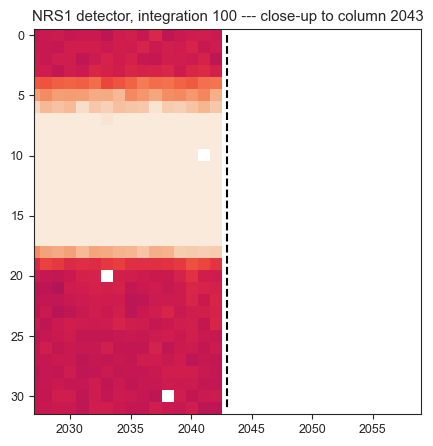

In [193]:
plt.figure(figsize=(5,5))
plt.title('NRS1 detector, integration 100 --- close-up to column 2043')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
plt.plot([2043, 2043], [0,31], 'k--')
plt.xlim(2043-16,2043+16)
im.set_clim(-10,10)

Indeed, entire column is a `nan`! Let's see how the ramps look like for one of those pixels. Say, row 15:

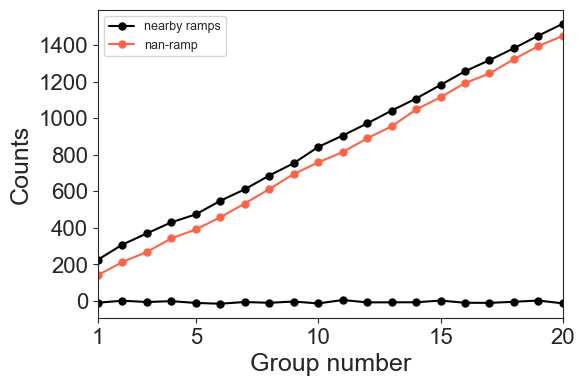

In [194]:
plt.figure(figsize=(6,4))


plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043-1], 'o-', color = 'black', label = 'nearby ramps')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043+1], 'o-', color = 'black')

plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043], 'o-', color = 'tomato', label = 'nan-ramp' )

plt.xlabel('Group number', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)

plt.xticks([0, 4, 9, 14, 19], 
           ['1', '5', '10', '15', '20'],
           fontsize = 16)

plt.yticks(fontsize = 16)


plt.xlim(0, 19)
plt.legend()

Interesting! There is nothing _particularly_ wrong with this ramp. One nearby ramp has zero flux because is a reference pixel (and thus doesn't respond to light). The other is a bit higher in counts, but very similar slope. So -- are _all_ the ramps `nan` for this column, or perhaps this is just the case for this integration?

In [196]:
nrs1_dataset.rateints[1].data[:, 15, 2043]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

They are _all_ `nan`! Hmmm. Let's plot _all_ the ramps on top of each other --- perhaps the ramp behaves weirdly and the jump detection is detecting and flagging this weirdness?

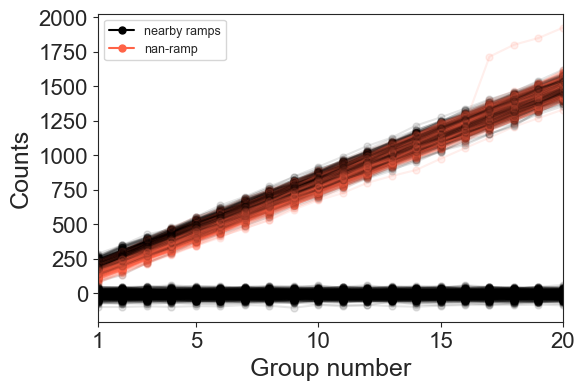

In [202]:
plt.figure(figsize=(6,4))

for i in range(nrs1_dataset.rateints[1].data.shape[0]):

    if i == 0:
        
        plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043-1], 'o-', color = 'black', label = 'nearby ramps')
        plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043+1], 'o-', color = 'black')
        
        plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043], 'o-', color = 'tomato', label = 'nan-ramp' )

    else:

        plt.plot( nrs1_dataset.ramps[1].data[i,:, 15, 2043-1], 'o-', color = 'black', alpha = 0.1)
        plt.plot( nrs1_dataset.ramps[1].data[i,:, 15, 2043+1], 'o-', color = 'black', alpha = 0.1)
        
        plt.plot( nrs1_dataset.ramps[1].data[i,:, 15, 2043], 'o-', color = 'tomato',alpha = 0.1)

plt.xlabel('Group number', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)

plt.xticks([0, 4, 9, 14, 19], 
           ['1', '5', '10', '15', '20'],
           fontsize = 16)

plt.yticks(fontsize = 16)


plt.xlim(0, 19)
plt.legend()

Huh. Nothing _particularly_ special about the ramp, other than a few outliers. So --- why is it `nan`? Well, there's another data-quality set of flags we haven't checked: the `groupdq`. Those are group-dependant data quality flags that are set up, typically by the `jump` step of the pipeline. Let's check it out for this ramp: 



In [205]:
nrs1_dataset.ramps[1].groupdq[100, :, 15, 2043]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

Huh. Nothing either! This is very strange. Time to report this perhaps.

Let's check now the other set of pixels, around coluns 1538, 1539 and 1540:

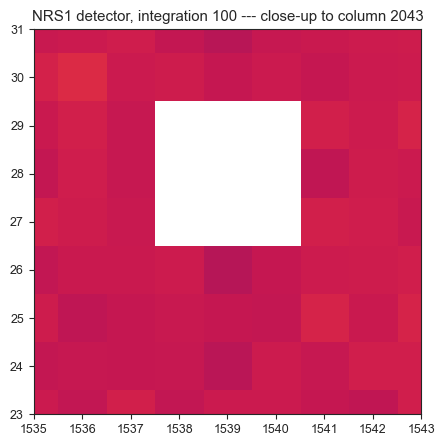

In [213]:
plt.figure(figsize=(5,5))
plt.title('NRS1 detector, integration 100 --- close-up to column 2043')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
plt.xlim(1539-4,1539+4)
plt.ylim(27-4,27+4)
im.set_clim(-10,10)

Interesting! A clear square of pixels. Let's grab one of them and figure out what is going on --- let's say pixel (28, 1538), and the two pixels to the left of it:

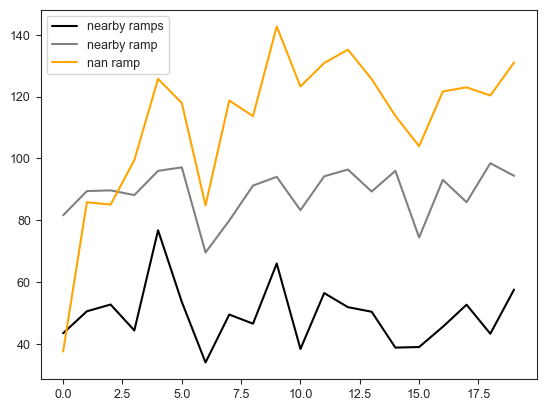

In [215]:
plt.plot( nrs1_dataset.ramps[1].data[100,:, 28, 1538-1], color = 'black', label = 'nearby ramps')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 28, 1538-2], color = 'grey', label = 'nearby ramp')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 28, 1538], color = 'orange', label = 'nan ramp' )

plt.legend()

Hmm. Nothing particularly weird with the ramp. Why is it `nan`? Pixel data-quality is...

In [207]:
nrs1_dataset.ramps[1].pixeldq[28, 1538]

0

...good; what about group data-quality:

In [209]:
nrs1_dataset.ramps[1].groupdq[100,:, 28, 1538]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=uint8)

Aha! This is marking it as 2, which is:

In [219]:
dqflags.dqflags_to_mnemonics(2, mnemonic_map = dqflags.pixel)

{'SATURATED'}

Saturated!? That is very weird. Is it the same for all pixels in the square?

In [221]:
for i in [27, 28, 29]:

    for j in [1538, 1539, 1540]:

        print(nrs1_dataset.ramps[1].groupdq[100,:, i, j])

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [222]:
dqflags.dqflags_to_mnemonics(3, mnemonic_map = dqflags.pixel)

{'DO_NOT_USE', 'SATURATED'}

Yes, except for one that is marked as both, saturated _and_ `DO_NOT_USE`. Time to report, too!